In [3]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as up
from stl import mesh
from mpl_toolkits import mplot3d
import pandas as pd
import sys
import os
sys.path.insert(1, '../../PENTrackAnalysis/')
import ParticlePlottingFunctions as ppf

### For data from the df file
* x,y,z are in cm
* B_i is in mT

Coordinate center is not know yet, but data was aquired from Takashi's 2019 mapping and processed using:
```
df_all['x'] = - df_all.u + 10.25
df_all['y'] = -df_all.w
df_all['z'] = df_all.v -1.25 +188.1 -275 #-> sets z = 0 to the center of the MSR 
# -1.25cm accounts for the position of the sensing center of the probe and the marker on the probe. 
# + 188.1cm: from z=0 of the measurement to the floor, -275cm: from the floor to the planned center of MSR
# df_all['z'] = df_all.v -1.25 ## previous version
```
so
z = 0 is at what ever the planed center of the MSR was at the time   
X and Y are swapped compared to what is in PENTrack - nope they aren't actually swapped, but quite rotated. In PENTrack the guides near the SCM are along x, where as for the mapping the path of the guides into the MSR is along y.

<img src="./Fig12.2_CDR2020_layout.jpg" width="500" />
<img src="./floorPlanMap2019.png" width="500" />

In [607]:
#make a cube
def MakeCube(axes, center=np.array([0,0,0]), sideLengths = np.array([1,2,3]) , c='black', angle=0):

    halfs_minus = [center[0]-sideLengths[0]/2, center[1]-sideLengths[1]/2, center[2]-sideLengths[2]/2]
    halfs_plus = [center[0]+sideLengths[0]/2, center[1]+sideLengths[1]/2, center[2]+sideLengths[2]/2]

    n = 20
    x_edge0 = np.linspace(halfs_minus[0], halfs_plus[0], n)
    y_edge0 = np.linspace(halfs_minus[1], halfs_plus[1], n)
    z_edge0 = np.linspace(halfs_minus[2], halfs_plus[2], n)
    
    x_min = halfs_minus[0]*np.ones(len(x_edge0))
    y_min = halfs_minus[1]*np.ones(len(x_edge0))
    z_min = halfs_minus[2]*np.ones(len(x_edge0))
    
    x_plus = halfs_plus[0]*np.ones(len(x_edge0))
    y_plus = halfs_plus[1]*np.ones(len(x_edge0))
    z_plus = halfs_plus[2]*np.ones(len(x_edge0))
    
    x_edge1, y_edge1 = rotate(np.array([x_edge0, y_min]).T, origin=center[:2], degrees=angle).T
    x_edge2, y_edge2 = rotate(np.array([x_min, y_edge0]).T, origin=center[:2], degrees=angle).T
    x_edge3, y_edge3 = rotate(np.array([x_min, y_min]).T, origin=center[:2], degrees=angle).T
    
    x_edge4, y_edge4 = rotate(np.array([x_edge0, y_plus]).T, origin=center[:2], degrees=angle).T
    x_edge5, y_edge5 = rotate(np.array([x_plus, y_edge0]).T, origin=center[:2], degrees=angle).T
    x_edge6, y_edge6 = rotate(np.array([x_plus, y_plus]).T, origin=center[:2], degrees=angle).T
    
    x_edge7, y_edge7 = rotate(np.array([x_edge0, y_min]).T, origin=center[:2], degrees=angle).T
    x_edge8, y_edge8 = rotate(np.array([x_min, y_edge0]).T, origin=center[:2], degrees=angle).T
    x_edge9, y_edge9 = rotate(np.array([x_min, y_plus]).T, origin=center[:2], degrees=angle).T
    
    x_edge10, y_edge10 = rotate(np.array([x_edge0, y_plus]).T, origin=center[:2], degrees=angle).T
    x_edge11, y_edge11 = rotate(np.array([x_plus, y_edge0]).T, origin=center[:2], degrees=angle).T
    x_edge12, y_edge12 = rotate(np.array([x_plus, y_min]).T, origin=center[:2], degrees=angle).T
    
    axes.scatter(center[0], center[1], center[2], color='yellow', marker='*', s=45, label="MSR center")

    axes.plot(x_edge1, y_edge1, z_min, c=c)
    axes.plot(x_edge2, y_edge2, z_min, c=c)
    axes.plot(x_edge3, y_edge3, z_edge0, c=c)

    axes.plot(x_edge4, y_edge4, z_plus, c=c)
    axes.plot(x_edge5, y_edge5, z_plus, c=c)
    axes.plot(x_edge6, y_edge6, z_edge0, c=c)

    axes.plot(x_edge7, y_edge7, z_plus, c=c)
    axes.plot(x_edge8, y_edge8, z_plus, c=c)
    axes.plot(x_edge9, y_edge9, z_edge0, c=c)

    axes.plot(x_edge10, y_edge10, z_min, c=c)
    axes.plot(x_edge11, y_edge11, z_min, c=c)
    axes.plot(x_edge12, y_edge12, z_edge0, c=c)

    return axes

def getCorners(data):
    x_dense_MSRframe = data['x']
    y_dense_MSRframe = data['y']
    z_dense_MSRframe = data['z']
    
    top_balc_M11 = [max(x_dense_MSRframe), max(y_dense_MSRframe), max(z_dense_MSRframe)]
    top_balc_cycl = [min(x_dense_MSRframe), max(y_dense_MSRframe), max(z_dense_MSRframe)]
    top_cycl_UCN = [min(x_dense_MSRframe), min(y_dense_MSRframe), max(z_dense_MSRframe)]
    top_M11_UCN = [max(x_dense_MSRframe), min(y_dense_MSRframe), max(z_dense_MSRframe)]

    bottom_balc_M11 = [max(x_dense_MSRframe), max(y_dense_MSRframe), min(z_dense_MSRframe)]
    bottom_balc_cycl = [min(x_dense_MSRframe), max(y_dense_MSRframe), min(z_dense_MSRframe)]
    bottom_cycl_UCN = [min(x_dense_MSRframe), min(y_dense_MSRframe), min(z_dense_MSRframe)]
    bottom_M11_UCN = [max(x_dense_MSRframe), min(y_dense_MSRframe), min(z_dense_MSRframe)]

    corners_MSRframe = np.array([top_balc_M11, top_balc_cycl, top_cycl_UCN, top_M11_UCN, bottom_balc_M11, 
               bottom_balc_cycl, bottom_cycl_UCN, bottom_M11_UCN]).T #cm
    
#     print(f"Max dimension in x: {np.abs(top_balc_cycl[0]-top_balc_M11[0])} , y:", 
#       f"{(top_balc_cycl[1]-top_cycl_UCN[1])}, z: {(top_balc_M11[2]-bottom_balc_M11[2])} cm")
    
    return corners_MSRframe

In [643]:
def rotate(p, origin=(0, 0), degrees=0):
    #https://stackoverflow.com/questions/34372480/rotate-point-about-another-point-in-degrees-python
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def rotate3D(p, origin=(0, 0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle), 0],
                  [np.sin(angle),  np.cos(angle), 0],
                  [0, 0, 1]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)

def refToMSR(data_T): #not done
    #center of MSR should be 0,0,0
    # y is parallel to the guide going into the MSR, x is, perpen to this
    #data going into this is Takashi's unchanged
    #but also I'm not totally sure the regions marked as F1 and C47 are the points I think they are
    
    #what units are these??
    centerToF1 = [36300.9 - 34527.4,1]
    print(centerToF1)
    data_T_to_f1 = [126, -187, 0] #cm, ignoring z here
    
    f1_to_center = centerToF1
    
    x_off_f1 = 161.2 - 126 # cm
    y_off = -27.5 # cm #from F1  -if this is the center??
    z_off = 0 # cm
    
    
def refToPENTrack(data_T, center_T):
    #center of SCM should be 0,0,0
    # x is parallel to the guide going into the SCM, y is perpen to this
    #data going into this is Takashi's unchanged
    
    x_off = 161.2 - 126 # cm
    y_off = 187 + 464.05 # cm
    z_off = 0 # cm
    
    center = np.array([center_T[0]+x_off, center_T[1]+y_off, center_T[2]+z_off])
    MSR_center = np.array([-22.3, 643.8,0])
    
    data_transf = data_T.copy()

    data_transf['x'] += x_off
    data_transf['y'] += y_off
    data_transf['z'] += z_off
    
    corners = getCorners(data_transf)
    
    return center, corners, data_transf, MSR_center
    

In [644]:
# file = "data_export/map_interpXcut50_[-141.8,98.2]_[-327.2,192.8]_[-180.0,250.0].csv"
file = "data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv"

In [701]:
#the initial data
df_BField_data = pd.read_csv(file, comment='#')

center_T = np.array([0, 0, 0])
data_T = df_BField_data[["x", "y", "z", "B_x", "B_y", "B_z"]]

#getting the correct shift to use in PENtrack, but not the coordinate rotation
center_PEN_notRot, corners_PEN_notRot, dataPEN_notRot, MSR_center_PEN_notRot = refToPENTrack(data_T, center_T)

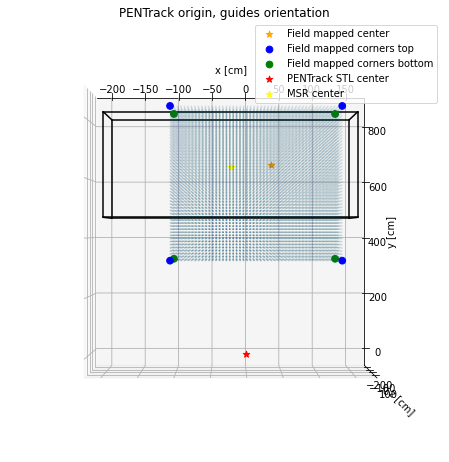

In [664]:
def plotMapping(ax, data, title, units="cm", view=0, angle=0, STLs=False, legend=True):
    center, corners, dataXB, MSR_center, Or = data

    ax.set_title(title, pad=-10)
    
    ax.scatter(center[0], center[1], center[2], color='orange', marker='*', s=45, label="Field mapped center")
    ax.scatter(corners[0,:4], corners[1,:4], corners[2,:4], color='blue', s=45, label="Field mapped corners top")
    ax.scatter(corners[0,4:], corners[1,4:], corners[2,4:], color='green', s=45, label="Field mapped corners bottom")

    ax.scatter(Or[0], Or[1], Or[2], color='red', marker='*', s=45, label="PENTrack STL center")
    
    if "cm" in units:
        MakeCube(ax, MSR_center, np.array([3.5,3.5,3.5])*100, angle=angle)
    elif "m" in units:
        MakeCube(ax, MSR_center, np.array([3.5,3.5,3.5]), angle=angle)
        
        if STLs:
            # #loads all the file I have in this folder as STLs
            STLpath = '../../PENTrackAnalysis/STLsToGraph'
            stl_array = os.listdir(STLpath)

            for STLfile in stl_array:
                ppf.graphSTL(STLpath+'/'+STLfile, ax, a=0.05)

    if view == 0:
        ax.view_init(elev=90., azim=-90)  #top view
    elif view == 1:
        ax.view_init(elev=0., azim=-90) #front view

    ax.set_xlabel(f'x [{units}]')
    ax.set_ylabel(f'y [{units}]')
    ax.set_zlabel(f'z [{units}]')
    if legend:
        ax.legend()
    
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d') 
data1 = [center_PEN_notRot, corners_PEN_notRot, dataPEN_notRot, MSR_center_PEN_notRot, O_PEN_notRot]
plotMapping(ax1, data1, title="PENTrack origin, guides orientation", view=0)

ax1.scatter(dataPEN_notRot['x'], dataPEN_notRot['y'], dataPEN_notRot['z'], s=1, alpha=0.01)
plt.show()    

In [724]:
def rotateBData(df_data, origin, angle):
    data_pos = rotate3D(df_data[['x', 'y', 'z']].values, origin=origin, degrees=angle)
    
    print(df_data[['B_x', 'B_y', 'B_z']].head())
    data_B = rotate3D(df_data[['B_x', 'B_y', 'B_z']].values, origin=origin, degrees=angle)
    print(f"after rotation of {angle} degrees")
    
    print(data_B[:5])
    
    
    df_data_rot = pd.DataFrame(data_pos, columns=['x', 'y', 'z'])
#     print(df_data_rot)
    df_data_rot[['B_x', 'B_y', 'B_z']] = data_B
    
    return df_data_rot

In [725]:
rotationAngle = -20 - 90 #20 degree switch from Y, plus swapping the x and y coords

O_PEN = O_PEN_notRot

center_PEN = rotate3D(center_PEN_notRot.T, origin=O_PEN_notRot, degrees=rotationAngle).T
corners_PEN = rotate3D(corners_PEN_notRot.T, origin=O_PEN_notRot, degrees=rotationAngle).T

data_PEN = rotateBData(data_PEN_notRot.copy(), O_PEN_notRot, rotationAngle)
# print(data_PEN)
# data_PEN[['x', 'y', 'z']] = rotate3D(data_PEN_notRot[['x', 'y', 'z']].values, origin=O_PEN_notRot, degrees=rotationAngle).T

MSR_center_PEN = rotate3D(MSR_center_PEN_notRot.T, origin=O_PEN_notRot, degrees=rotationAngle).T

        B_x       B_y       B_z
0 -1.522228 -0.075550 -0.675982
1 -1.484841 -0.161230 -0.682451
2 -1.433774 -0.233065 -0.687607
3 -1.379666 -0.291707 -0.693168
4 -1.334950 -0.336697 -0.702810
after rotation of -110 degrees
[[ 0.44963924  1.4562659  -0.675982  ]
 [ 0.35633872  1.45043849 -0.68245132]
 [ 0.27136982  1.42702029 -0.68760665]
 [ 0.19775887  1.39623158 -0.69316761]
 [ 0.1401884   1.36959924 -0.70280991]]


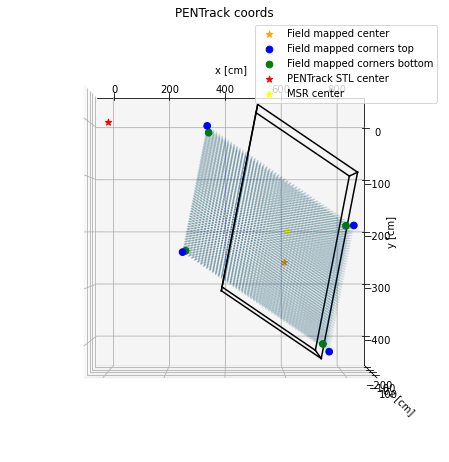

In [726]:
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d') 
data = [center_PEN, corners_PEN, data_PEN, MSR_center_PEN, O_PEN]
plotMapping(ax1, data, title="PENTrack coords", view=0, angle=rotationAngle)

ax1.scatter(data_PEN['x'], data_PEN['y'], data_PEN['z'], s=1, alpha=0.01)

plt.show()    

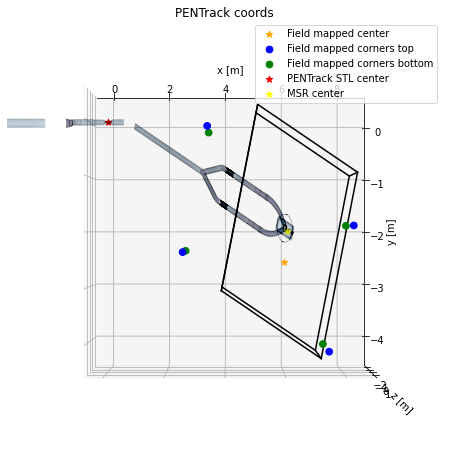

In [651]:
center_PEN_m = center_PEN/100
corners_PEN_m = corners_PEN/100
MSR_center_PEN_m = MSR_center_PEN/100
data_PEN_m = data_PEN/100

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d') 
data2 = [center_PEN_m, corners_PEN_m, data_PEN_m, MSR_center_PEN_m, O_PEN]
plotMapping(ax1, data2, title="PENTrack coords", view=0, angle=rotationAngle, units="m", STLs=True)
plt.show()    

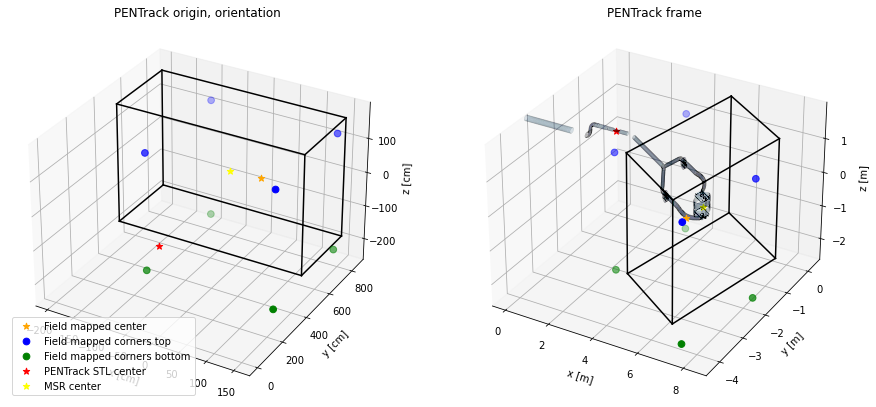

In [657]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

plotMapping(ax1, data1, title="PENTrack origin, orientation", view=4)
plotMapping(ax2, data2, title="PENTrack frame", view=4, angle=rotationAngle, units="m", STLs=True, legend=False)
plt.show()  

## Reformating of B files for PENTrack

In [111]:
def FixOffset(BField_data):
#     x_off = 0 # cm
#     y_off = -100 # cm
#     z_off = 0 # cm
    off_sets = np.array([x_off, y_off, z_off])
    # numpy.ndarray.copy

    BField_data2 = BField_data.copy()
    BField_data2[1:4] = BField_data2[1:4] + off_sets[:,None]
    return BField_data2, off_sets

In [112]:
from datetime import date
file = "data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv"
BField_Names = np.genfromtxt(file, delimiter=',', names=True).dtype.names[1:]

BField_data = np.genfromtxt(file, delimiter=',', skip_header=1).T

BField_data, off_sets = FixOffset(BField_data)

BField_data = BField_data[1:].T #remove the first line of indexes

In [115]:
# len(BField_data[0]) #check units again
comment = "This data, interpolated from Takashi's summer 2019 data is not position referenced properly,"+\
    " as the origin is currently not the same as that used in the PENTrack STL files."
headerText = f'File: {file}\n' + f'Date created: {date.today().strftime("%d/%m/%Y")}\n'\
    + 'Units: [cm], [mT]\n' +f'Offset from original data used: {off_sets} cm\n' + f'Comments: {comment}\n'\
    + '\t'.join(BField_Names)
print(headerText)

File: data_export/map_interp50_[-141.8,98.2]_[-327.2,192.8]_[-234.3,114.2].csv
Date created: 05/08/2022
Units: [cm], [mT]
Offset from original data used: [10.  40.4 25. ] cm
Comments: This data, interpolated from Takashi's summer 2019 data is not position referenced properly, as the origin is currently not the same as that used in the PENTrack STL files.
x	y	z	B_x	B_y	B_z


In [110]:
# BField_Names
np.savetxt('./data_export/map_interp50_notRef.txt', BField_data,  delimiter='\t', newline='\n', header=headerText)